# FreeCAD + Sympy-Mechanics -> Rotating Box

## Imports

In [2]:
from __future__ import division

import FreeCAD as App

import numpy as np
np.set_printoptions(precision=3)

import sympy
from sympy.physics import mechanics
sympy.init_printing()

from pydy.codegen.ode_function_generators import generate_ode_function

from scipy.integrate import odeint

from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (20.0, 6.0)
%matplotlib inline

from PySide import QtCore
import time

## Helpers

In [3]:
def mat_to_np(mat):
    elements = mat.A
    return np.array([[elements[j * 4 + i] for i in range(4)] for j in range(4)])

def np_to_mat(np_mat):
    App.Matrix(*np_mat.flatten())

def vec_to_np(vec):
    return np.array(list(vec))

## CAD input

In [4]:
rho = 7800 / 1000 ** 3
document = App.getDocument("Rotating_Box_2")

In [5]:
box_1 = document.Box
inert_1 = mat_to_np(box_1.Shape.MatrixOfInertia) * rho
mass_1 = box_1.Shape.Volume * rho
cog_1 = vec_to_np(box_1.Shape.CenterOfMass)
width_1 = box_1.Width.Value
cog_1

array([ 5.,  5.,  5.])

In [6]:
box_2 = document.Box001
inert_2 = mat_to_np(box_2.Shape.MatrixOfInertia) * rho
inert_2 = inert_1
mass_2 = box_2.Shape.Volume * rho
cog_2 = vec_to_np(box_2.Shape.CenterOfMass)
cog_2

array([ 15.,   5.,   5.])

## Kinematic

### Reference Frames

In [7]:
I = mechanics.ReferenceFrame("I")
R_11 = mechanics.ReferenceFrame("R_11")
R_12 = mechanics.ReferenceFrame("R_12")
B_1 = mechanics.ReferenceFrame("B_1")
R_21 = mechanics.ReferenceFrame("R_21")
R_22 = mechanics.ReferenceFrame("R_22")
B_2 = mechanics.ReferenceFrame("B_2")

In [8]:
theta_1 = mechanics.dynamicsymbols("theta_1x theta_1y theta_1z")
theta_2 = mechanics.dynamicsymbols("theta_2x theta_2y theta_2z")
theta = theta_1 + theta_2
omega_1 = mechanics.dynamicsymbols("omega_1x omega_1y omega_1z")
omega_2 = mechanics.dynamicsymbols("omega_2x omega_2y omega_2z")
omega = omega_1 + omega_2
R_11.orient(I, "Axis", (theta_1[2], I.z))
R_12.orient(R_11, "Axis", (theta_1[1], R_11.y))
B_1.orient(R_12, "Axis", (theta_1[0], R_12.x))
R_21.orient(I, "Axis", (theta_2[2], I.z))
R_22.orient(R_21, "Axis", (theta_2[1], R_21.y))
B_2.orient(R_22, "Axis", (theta_2[0], R_22.x))

In [9]:
R_11.set_ang_vel(I, omega_1[2] * I.z)
R_12.set_ang_vel(R_11, omega_1[1] * R_11.y)
B_1.set_ang_vel(R_12, omega_1[0] * R_12.x)
R_21.set_ang_vel(I, omega_2[2] * I.z)
R_22.set_ang_vel(R_21, omega_2[1] * R_21.y)
B_2.set_ang_vel(R_22, omega_2[0] * R_22.x)

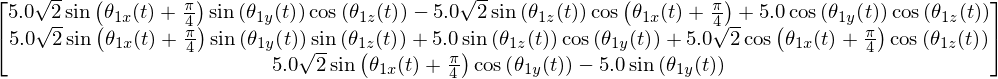

In [10]:
origin_1 = mechanics.Point("O_1")
origin_1.set_vel(I, 0)
box_cog_1 = origin_1.locatenew("COG_1", cog_1[0] * B_1.x + cog_1[1] * B_1.y + cog_1[2] * B_1.z)
box_cog_1.v2pt_theory(origin_1, I, B_1)
sympy.simplify(box_cog_1.pos_from(origin_1).to_matrix(I))

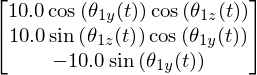

In [11]:
origin_2 = origin_1.locatenew("O_2", width_1 * B_1.x)
origin_2.v2pt_theory(origin_1, I, B_1)
sympy.simplify(origin_2.pos_from(origin_1).to_matrix(I))

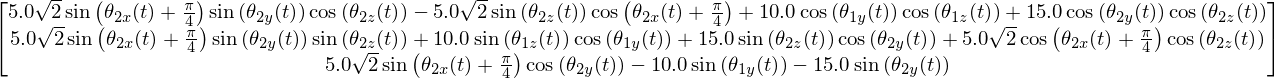

In [12]:
box_cog_2 = origin_2.locatenew("COG_2", cog_2[0] * B_2.x + cog_2[1] * B_2.y + cog_2[2] * B_2.z)
box_cog_2.v2pt_theory(origin_2, I, B_2)
sympy.simplify(box_cog_2.pos_from(origin_1).to_matrix(I))

## Inertia

In [13]:
inertia_1 = mechanics.inertia(B_1, inert_1[0, 0], inert_1[1, 1], inert_1[2, 2])
inertia_2 = mechanics.inertia(B_2, inert_2[0, 0], inert_2[1, 1], inert_2[2, 2])

In [14]:
box_body_1 = mechanics.RigidBody("box_1", box_cog_1, B_1, mass_1, (inertia_1, box_cog_1))
box_body_2 = mechanics.RigidBody("box_2", box_cog_2, B_2, mass_2, (inertia_2, box_cog_2))

## Loads

In [15]:
g = 9.81
mass_force_1 = -g * mass_1 * I.z
mass_force_2 = -g * mass_2 * I.z
forces = [(box_cog_1, mass_force_1),
          (box_cog_2, mass_force_2)]

## Equation

In [16]:
kin_diff = [om - thet.diff("t") for om, thet in zip(omega, theta)]
km = mechanics.KanesMethod(I, theta, omega, kin_diff)

In [17]:
fr, frstar = km.kanes_equations(forces, [box_body_1, box_body_2])
force = km.forcing_full
mass_matrix = km.mass_matrix_full

In [18]:
rhs = generate_ode_function(force, theta, omega, [], mass_matrix)

## numerical solve/integrate the ode

In [19]:
x0 = np.zeros(12)
t_end = 10
fps = 24
t = np.linspace(0, t_end, t_end * fps)
y = odeint(rhs, x0, t, args=({},))

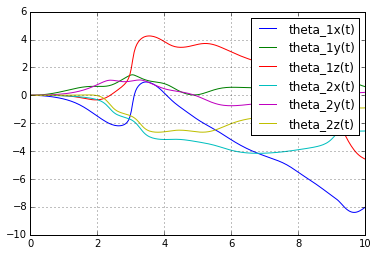

In [20]:
plt.grid()
plt.plot(t, y[:,:6])
plt.legend(theta)


## Visualisation

In [21]:
def reset_position():
    box_1.Placement.Rotation = App.Rotation(0, 0, 0)
    box_2.Placement.Rotation = App.Rotation(0, 0, 0)
    box_2.Placement.Base = App.Vector(width_1, 0, 0)

In [22]:
i = 0
def update(*args):
    global i
    if i == len(y):
        i = 0
    origin_2_num = origin_2.pos_from(origin_1).to_matrix(I).subs(dict(zip(theta, y[i][:6])))
    box_1.Placement.Rotation = App.Rotation(*np.rad2deg(y[i][:3][::-1]))
    box_2.Placement.Base = App.Vector(0, 0, 0)
    box_2.Placement.Rotation = App.Rotation(*np.rad2deg(y[i][3:6][::-1]))
    box_2.Placement.Base = App.Vector(*origin_2_num)
    i += 1

In [25]:
timer = QtCore.QTimer()
timer.setInterval(1000 * 1 / fps)
timer.timeout.connect(update)
timer.start()

In [24]:
timer.stop()
reset_position()
del(timer)